In [3]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import pandas as pd
from pathlib import Path

In [4]:
path = fv.untar_data(fv.URLs.PLANET_SAMPLE)

In [6]:
path.ls()

(#2) [Path('/storage/data/planet_sample/train'),Path('/storage/data/planet_sample/labels.csv')]

In [10]:
imgs = (path/'train').ls()

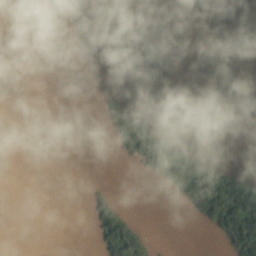

In [11]:
fv.PILImage.create(imgs[10])

In [12]:
fv.PILImage.create(imgs[19]).width

256

In [13]:
df = pd.read_csv(path/'labels.csv');df

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
...,...,...
995,train_1876,cloudy
996,train_10311,clear primary road water
997,train_19080,clear primary
998,train_39339,clear primary road


In [15]:
file2tags = dict(zip(df['image_name'],df['tags']))
{k: v for k, v in file2tags.items() if random.random() < 0.01}

{'train_37993': 'clear primary',
 'train_3667': 'clear primary road',
 'train_39194': 'agriculture clear cultivation habitation primary road water',
 'train_23687': 'artisinal_mine clear primary road water'}

In [18]:
def obtener_categorias(f): #le paso archivo
    return file2tags[f.stem] #.stem quita la extención y directorio padre, se queda con el nombre del archivo

In [19]:
obtener_categorias(imgs[19])

'partly_cloudy primary'

In [22]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert = True,
                             max_rotate=360,
                             max_lighting = 0.35,
                             max_zoom = 1.1,
                             max_warp=0.01)
    
    data = fv.DataBlock( blocks = (fv.ImageBlock, fv.MultiCategoryBlock),
                        get_items = fv.get_image_files,
                        get_y = obtener_categorias,
                        splitter = fv.RandomSplitter(1/10), #voy a dejar 10% de validación
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms = tfms)
    return data.dataloaders(folder, bs=batch_size)

In [23]:
data = load_data(path, 224, 128)

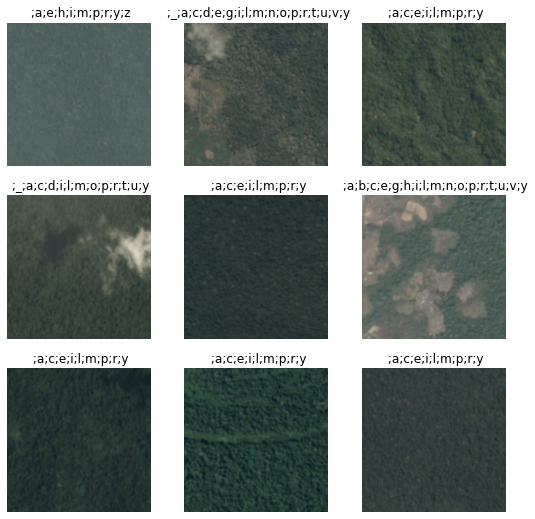

In [24]:
data.show_batch()

In [25]:
def obtener_categorias(f):
    return file2tags[f.stem].split(' ')

In [26]:
obtener_categorias(imgs[19])

['partly_cloudy', 'primary']

In [27]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert = True,
                             max_rotate=360,
                             max_lighting = 0.35,
                             max_zoom = 1.1,
                             max_warp=0.01)
    
    data = fv.DataBlock( blocks = (fv.ImageBlock, fv.MultiCategoryBlock),
                        get_items = fv.get_image_files,
                        get_y = obtener_categorias,
                        splitter = fv.RandomSplitter(1/10), #voy a dejar 10% de validación
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms = tfms)
    return data.dataloaders(folder, bs=batch_size)

In [28]:
data = load_data(path, 224, 128)

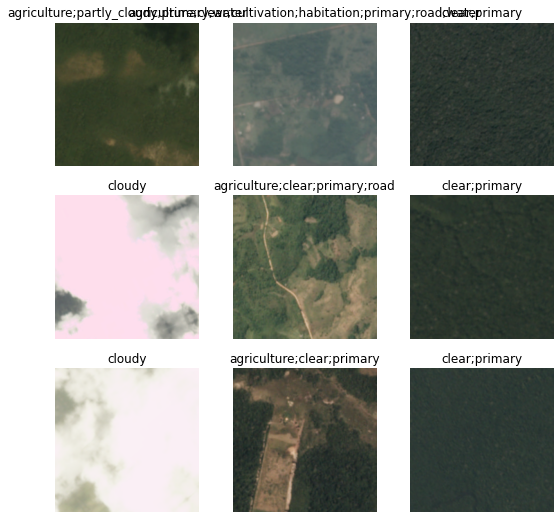

In [30]:
data.show_batch()

In [31]:
x,y = data.one_batch()

In [32]:
x.shape

torch.Size([128, 3, 224, 224])

In [33]:
y.shape

torch.Size([128, 17])

In [34]:
y[:3]

TensorMultiCategory([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1.]],
       device='cuda:0')

In [35]:
class Normalizer(nn.Module):
    def __init__(self, mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]): 
        super().__init__()
        self.mean = torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self,x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x-m)/s

In [38]:
def create_learner(**kwargs):
    learn = fv.cnn_learner(data, fv.resnet18, opt_func=fv.ranger, normalize=False, **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [39]:
learn = create_learner(metrics = fv.accuracy_multi) #no accuracy, porque espera números y no vectores de 0s y 1s

In [42]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

## Predicciones

In [43]:
learn.loss_func #BinaryCrossEntropy

FlattenedLoss of BCEWithLogitsLoss()

In [44]:
F.binary_cross_entropy_with_logits? #hay una sin logits, no la uses

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.10000000149011612)

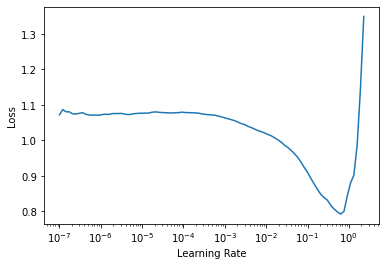

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(1,2e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.907598,0.695588,0.591765,00:08


## Score F2

In [47]:
fv.FBetaMulti(beta=2)

In [49]:
learn = create_learner(metrics=[fv.accuracy_multi,fv.FBetaMulti(beta=2, average='samples')])

In [50]:
learn.fit_one_cycle(4,2e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,1.051394,0.821707,0.500000,0.375533,00:07
1,0.999905,0.644709,0.692353,0.584788,00:07
2,0.932426,0.611210,0.684706,0.619647,00:06
3,0.867442,0.576496,0.712941,0.650860,00:06


In [52]:
thresholds = [0.1,0.25,0.5,0.75]
metrics = [fv.FBetaMulti(beta=2, thresh=t) for t in thresholds]

metrics += [fv.accuracy_multi]

learn = create_learner(metrics=metrics)

In [53]:
learn.fit_one_cycle(1,2e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,fbeta_score,fbeta_score,fbeta_score,fbeta_score,accuracy_multi,time
0,1.059424,0.749398,0.321990,0.302111,0.203382,0.093486,0.516471,00:07


In [55]:
fv.AccumMetric.name= ""
thresholds = [0.1,0.25,0.5,0.75,0.9]
metrics = [fv.FBetaMulti(beta=2, thresh=t) for t in thresholds]

for m,t in zip(metrics,thresholds):
    m.name =f"F2@{t}"
    
metrics += [fv.accuracy_multi]

In [56]:
learn.fit_one_cycle(5,2e-3,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,,,,,accuracy_multi,time
0,1.009953,0.722511,0.325904,0.338814,0.336985,0.219454,0.575294,00:07
1,0.974054,0.722965,0.329244,0.341719,0.342636,0.247438,0.572353,00:06
2,0.951676,0.697324,0.331148,0.353267,0.370052,0.323463,0.604706,00:06
3,0.935615,0.672966,0.334358,0.358089,0.389933,0.357663,0.632941,00:06
4,0.918351,0.678268,0.335191,0.358387,0.383471,0.363234,0.625882,00:06


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0691830962896347)

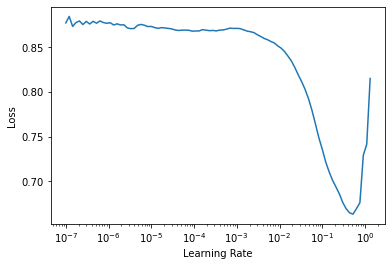

In [57]:
learn.lr_find()

In [58]:
learn.fit_one_cycle(12,2e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,,,,,accuracy_multi,time
0,0.831257,0.824779,0.343750,0.362601,0.402308,0.410813,0.639412,00:06
1,0.780085,0.646238,0.348324,0.379757,0.407941,0.379913,0.751176,00:06
2,0.702578,0.418216,0.356895,0.413318,0.448170,0.420297,0.875294,00:06
3,0.612300,0.267423,0.393706,0.450564,0.463700,0.405893,0.934118,00:06
4,0.522948,0.154666,0.462389,0.487323,0.423370,0.337988,0.955294,00:06
5,0.442806,0.122285,0.475386,0.452751,0.419206,0.345977,0.958235,00:06
6,0.381325,0.114002,0.476533,0.449443,0.436133,0.339049,0.962941,00:06
7,0.336838,0.131934,0.475281,0.447860,0.384076,0.345200,0.954118,00:06
8,0.301154,0.115338,0.458083,0.471229,0.410842,0.305220,0.962353,00:06
9,0.272169,0.111283,0.484567,0.490245,0.429385,0.353963,0.960000,00:06


/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


In [59]:
learn.unfreeze()

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=3.311311274956097e-06)

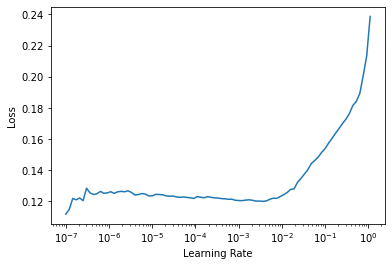

In [60]:
learn.lr_find()

In [61]:
learn.fit_one_cycle(12,slice(3e-5,1e-3), div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,,,,,accuracy_multi,time
0,0.117555,0.105231,0.542860,0.474244,0.407888,0.344143,0.963529,00:08
1,0.116427,0.102736,0.489871,0.479421,0.409474,0.323112,0.962941,00:08
2,0.118354,0.103831,0.545343,0.487020,0.434349,0.321234,0.965294,00:08
3,0.117219,0.102570,0.548854,0.484369,0.427553,0.328349,0.963529,00:08
4,0.117397,0.103044,0.554480,0.467913,0.413261,0.322963,0.962941,00:08
5,0.118106,0.100826,0.550243,0.482042,0.407561,0.332204,0.962941,00:08
6,0.117674,0.098777,0.555384,0.503313,0.414030,0.329265,0.963529,00:08
7,0.117046,0.101437,0.558286,0.499991,0.423790,0.314877,0.964706,00:08
8,0.115424,0.102567,0.555920,0.473758,0.430994,0.343293,0.964706,00:08
9,0.113540,0.100680,0.552256,0.471622,0.419216,0.359845,0.964706,00:08


In [62]:
thresholds = [0.15 + i*0.01 for i in range(20)]
metrics = [fv.FBetaMulti(beta=2,thresh=t, average='samples') for t in thresholds]

for m,t in zip(metrics,thresholds):
    m.name = f"F2@{t}"

metrics += [fv.accuracy]

In [63]:
learn.metrics = metrics

In [71]:
vali = learn.validate